# Data Challenge 7 — Evaluating SLR, Assumptions, & the Bias–Variance Tradeoff

**Goal:** Fit a simple linear regression (SLR) with a **train–test split**, report **MAE/RMSE** on *unseen* data, and use **training residuals** to check assumptions. Explain **bias vs. variance** in plain English.


> Dataset: **NYC Yellow Taxi — Dec 2023** (CSV). Keep code *simple* — minimal coercion for chosen columns only.

## We Do — Instructor Session (20 mins)
Use this **step-by-step plan** to guide students. Keep it high-level; they will implement in the *You Do* section.

**Docs (quick links):**
- Train/Test Split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- MAE / MSE / RMSE — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
- OLS (fit/predict/residuals) — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
- OLS Results (attributes like `resid`, `fittedvalues`, `summary`) — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html
- Q–Q plot — SciPy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html

### Pseudocode Plan
1) **Load CSV** → preview columns/shape.
2) **Assign Y and X (one predictor)** → pick numeric columns that matter; if needed, coerce **just** these to numeric and drop NAs.
3) **Add intercept** → `X = add_constant(X)`.
4) **Train–test split (80/20)** → `X_train, X_test, y_train, y_test = train_test_split(...)` (set `random_state`).
5) **Fit on TRAIN** → `model = OLS(y_train, X_train).fit()`.
6) **Predict on TEST** → `y_pred = model.predict(X_test)`.
7) **Evaluate on TEST** → compute **MAE** and **RMSE** using `y_test` & `y_pred`; speak in **units of Y**.
8) **Diagnostics on TRAIN** → use `model.resid` & `model.fittedvalues` for residuals vs fitted; Q–Q plot; check Durbin–Watson in `model.summary()`.
9) **Bias–variance read (optional)** → compare train vs test errors.
10) **Stakeholder one-liner** → MAE/RMSE in units + brief reliability note.


## You Do — Student Section
Work in pairs. Keep code simple and comment your choices.

### Step 0 — Setup & Imports

In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = '/Users/Marcy_Student/Desktop/Marcy-Modules/marcy-git/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv'

df = pd.read_csv(path)

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_79436/608864315.py:3: DtypeWarning: Columns (4,10,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [3]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,12/01/2023 04:11:39 PM,12/01/2023 04:19:13 PM,2.0,0.69,1.0,N,141,140,1,7.9,2.5,0.5,3.0,0.00,1.0,17.4,2.5,0.00
1,1,12/01/2023 04:11:39 PM,12/01/2023 04:20:41 PM,3.0,1.1,1.0,N,236,263,2,10.0,5.0,0.5,0.0,0.00,1.0,16.5,2.5,0.00
2,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,-10.7,-2.5,-0.5,0.0,0.00,-1.0,-17.2,-2.5,0.00
3,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,10.7,2.5,0.5,0.0,0.00,1.0,17.2,2.5,0.00
4,1,12/01/2023 04:11:39 PM,12/01/2023 04:34:39 PM,2.0,3,1.0,N,164,211,1,21.9,5.0,0.5,3.0,0.00,1.0,31.4,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3310902,2,01/01/2024 12:01:58 AM,01/01/2024 12:10:04 AM,3.0,1.7,1.0,N,234,144,1,10.7,1.0,0.5,2.36,0.00,1.0,18.06,2.5,0.00
3310903,2,01/03/2024 10:00:04 AM,01/03/2024 11:08:22 AM,1.0,21.6,1.0,N,132,136,1,82.1,0.0,0.5,18.46,6.94,1.0,110.75,0.0,1.75
3310904,2,01/03/2024 05:00:52 PM,01/03/2024 05:01:05 PM,2.0,0.0,5.0,N,265,265,1,120.0,0.0,0.0,0.0,0.00,1.0,121.0,0.0,0.00
3310905,2,01/03/2024 06:43:26 PM,01/03/2024 06:43:29 PM,2.0,0.01,5.0,N,95,95,1,86.69,0.0,0.0,17.54,0.00,1.0,105.23,0.0,0.00


In [4]:
# woah (just curious)
df.loc[df['tolls_amount']==df['tolls_amount'].max()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1782542,1,12/15/2023 07:11:15 PM,12/15/2023 07:13:17 PM,2.0,6.5,3.0,N,265,265,3,23.7,2.5,0.0,0.0,161.38,1.0,188.58,0.0,0.0


In [26]:
# also curious
df['trip_distance'].mean()

np.float64(3.7625720731629233)

### Step 1 & 2 — Read in the file and Choose **Y** (target) and **X** (one predictor)
- Keep them numeric and present in your CSV.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [5]:
# Coerce fare, tip, distance to numeric safely
num_cols = ['fare_amount', 'tip_amount', 'trip_distance']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce'
    )

In [32]:
# Clean data some and add a new column called 'tip_pct' as the target 
df = df[(df['fare_amount'] > 0) & (df['tip_amount'] >= 0) & (df['trip_distance'] > 0) & (df['trip_distance'] < 160) & (df['fare_amount'] < 560)]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=num_cols)
df['tip_pct'] = (df['tip_amount']/df['fare_amount']).clip(0,1)

### **For clarity:**

- I filtered trip_distance to be between 0 - 160, since I believe anything over 160 miles is an outlier. For reference, New York State is approximately 330 miles long from east to west and 283 miles wide from north to south (according to [this website](https://www.netstate.com/states/geography/ny_geography.htm)). Considering the Taxi & Limousine Commission (TLC) is based in NYC, I would consider anything over 160 miles to be a far outlier.

- Filtered fare_amount to under $560. Taxis charge $3.00 initial fee, plus 70 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped (according to [this website](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page)). Simply generalized by doing $0.70 x 5 to get charger per mile, then $3.50 * 160 to get a very rough max charge rate based on our filtered trip_distance.

In [35]:
# splitting into our data yahurd (also adding our intercept to x)
x = sm.add_constant(df[['trip_distance']])
y = df['fare_amount']

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

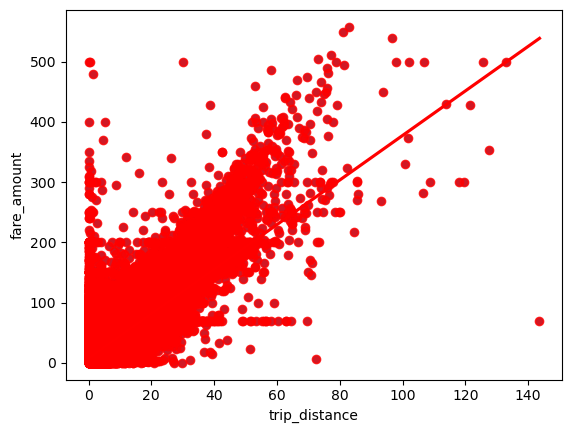

In [36]:
sns.scatterplot(df, x='trip_distance', y='fare_amount')
sns.regplot(df, x='trip_distance', y='fare_amount', color='red')

### Step 3 — Train–Test Split (80/20 random split for practice)

In [37]:
# test/split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)

### Step 4 — Fit on TRAIN only; Evaluate on TEST
Compute **MAE** and **RMSE** in the **units of Y**.

In [38]:
# insert our train to our model
model = sm.OLS(y_train, x_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                 1.541e+07
Date:                Tue, 11 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:12:31   Log-Likelihood:            -8.4840e+06
No. Observations:             2560157   AIC:                         1.697e+07
Df Residuals:                 2560155   BIC:                         1.697e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.5442      0.005   1443.329      0.000       7.534       7.554
trip_distance     3.6989      0.001   3926.036      0.000       3.697       3.701
==============================================================================
Omnibus:                  3056875.613   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2410664166.704
Skew:                           5.691   Prob(JB):                         0.00
Kurtosis:                     152.897   Cond. No.                         7.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# our y prediction
y_pred = model.predict(x_test)

# using this and y-test for MAE / RMSE
MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nMean Absolute Error (MAE) on Test Data: {MAE:.2f}")
print(f"Root Mean Squared Error (RMSE) on Test Data: {RMSE:.2f}")
print(f"\nInterpretation: Our model's predictions on new data are off by an average of ${MAE:,.2f}.")


Mean Absolute Error (MAE) on Test Data: 3.78
Root Mean Squared Error (RMSE) on Test Data: 6.66

Interpretation: Our model's predictions on new data are off by an average of $3.78.


### Step 5 — Diagnostic Plots (TRAIN residuals)
Check regression assumptions using **training** residuals.
- **Homoscedasticity:** random cloud around 0 (no cone).
- **Normality:** Q–Q plot ~ diagonal.

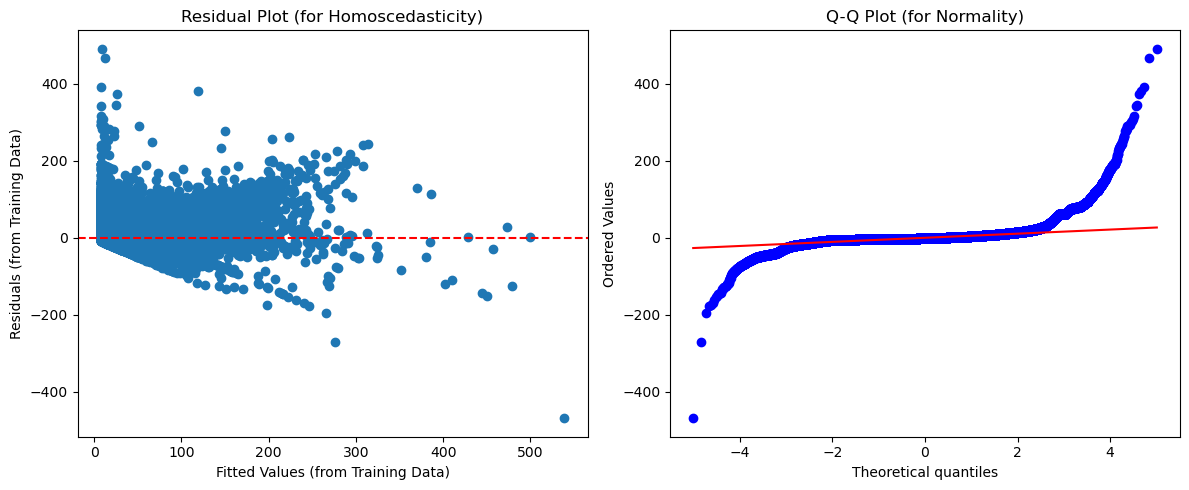

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                 1.541e+07
Date:                Tue, 11 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:16:58   Log-Likelihood:            -8.4840e+06
No. Observations:             2560157   AIC:                         1.697e+07
Df Residuals:                 2560155   BIC:                         1.697e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.5442      0.005   1443.329      0.000       7.534       7.554
trip_distance     3.6989      0.001   3926.036      0.000       3.697       3.701
==============================================================================
Omnibus:                  3056875.613   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2410664166.704
Skew:                           5.691   Prob(JB):                         0.00
Kurtosis:                     152.897   Cond. No.                         7.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
import scipy.stats as stats

# --- Check assumptions using the training data model ---
# Residuals from the model trained on X_train, y_train
train_residuals = model.resid 

# 1. Plot for Homoscedasticity
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(model.fittedvalues, train_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (for Homoscedasticity)')
plt.xlabel('Fitted Values (from Training Data)')
plt.ylabel('Residuals (from Training Data)')

# 2. Q-Q Plot for Normality
plt.subplot(1, 2, 2)
stats.probplot(train_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (for Normality)')

plt.tight_layout()
plt.show()

# 3. Durbin-Watson statistic is in the summary output below
display(model.summary())

1. **Plotting Residuals for Homoscedasticity**
    - We see no clear pattern, which is a good sign. (Although one could argue that there is a slight cone shape, I believe it is more happenstance than a true pattern.) This is telling us that our predictions are going to be accurate across the entire range of X / Y.

2. **Q-Q Plot for Normality**
    - Here, we can see that the points fall well on the diagonal line, indicating that our model is estimating well, not over or underestimating.

3. **Independence of Residuals (Durbin-Watson)**
    - Our value here is 2, which is good. It's telling us that our model's errors are truly random and not influential of the previous/next error.

### Step 6 — Quick Bias–Variance Read (optional)
Compare **train** and **test** errors and describe what you see.

In [55]:
# testing errors for train
train_pred = model.predict(x_train)

MAE2 = mean_absolute_error(y_train, train_pred)
RMSE2 = np.sqrt(mean_squared_error(y_train, train_pred))

print(f'Train MAE: {MAE2} ---- Test MAE: {MAE}')
print(f'Train RMSE: {RMSE2} ---- Test RMSE: {RMSE}')

if MAE2 < MAE:
    print('\nPossibly overfitting? (model is performing better on train data)')
else:
    print('model could be underfitted, or is generalizing well')

if RMSE2 < RMSE:
    print('train RMSE is lower.')
else:
    print('train RMSE is higher')

print('\nThis is good. Tells us that the model is performing well.')

Train MAE: 3.7843881399713246 ---- Test MAE: 3.7838356757443536
Train RMSE: 6.651992366274336 ---- Test RMSE: 6.664352970298566
model could be underfitted, or is generalizing well
train RMSE is lower.

This is good. Tells us that the model is performing well.


## We Share — Reflection & Wrap‑Up
Write **1–2 short paragraphs** addressing:


1) **Is this model good enough** for a real decision **right now**? Why/why not?
Refer to **MAE/RMSE in units**, any **assumption issues**, and whether accuracy meets a reasonable business threshold.


2) **What’s your next move** to improve trust/accuracy?
Examples: adopt a **time‑aware split**, try a more relevant **X**, transform variables, segment checks (hour/zone), or move to **Multiple Linear Regression** with validation.

I believe this model is very good, despite the fact that we are only using one variable for a simple linear regression. Logically, trip distance is a key contributing factor to fare amount. When calculating our errors, I found the values to be very low, indicating that our predictions are only off by roughly $3.78. Also looking into our residuals, my observations indicate to me that the the errors should be small and random; our model isn't just memorizing noise, any errors it is making is truly random.

For my next move, I feel confident moving onto Multiple Linear Regression, likely adding in ride time that likely contributes more to the variation of fare amount.

What also comes to mind could be transforming my X rather than filtering based on my research. Perhaps a log function, or something that could reduce the outliers. However, I generally feel confident in my decisions to filter the data.